In [1]:
from pyaudi import gdual, sin, cos, tanh, exp
import pyaudi
import theano
import theano.tensor as T
import lasagne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pickle
import time
%matplotlib nbagg

Neural network
-----

The actual network is implemented as part of my audi git repository, make sure you have that one installed.

In [2]:
def isfunction(x):
    return hasattr(x, '__call__')

In [3]:
class CNeuralNetwork:
    def __init__(self, num_inputs):
        self.nn = pyaudi.NeuralNetwork(num_inputs)
        
    def __call__(self, values):
        values = self.nn(values)
            
        if len(values) == 1:
            return values[0]
        
        return values
    
    def get_all_parameters(self):
        for layer in self.nn.get_layers():
            for parameter in layer.get_parameters():
                yield(parameter)
                
    def set_all_parameters(self, parameters):
        start = 0
        
        for layer in self.nn.get_layers():
            length = len(layer.get_parameters())
            layer.set_parameters(parameters[start:start+length])
            start += length
            
def CDenseLayer(incoming, num_units, W=np.random.randn, b=0.0, nonlinearity=tanh):
    if isfunction(b):
        bias_fun = b
    else:
        bias_fun = lambda: b

    if isfunction(W):
        weight_fun = W
    else:
        weight_fun = lambda: W

    dl = pyaudi.DenseLayer(len(incoming.nn.get_layers()), incoming.nn.num_outputs, num_units, weight_fun, bias_fun, nonlinearity)
    incoming.nn.add_layer(dl)
    return dl

NeuralNetwork = CNeuralNetwork
DenseLayer = CDenseLayer

In [4]:
def squared_error(a, b):
    return (a - b) ** 2

In [5]:
def sgd(loss, params, learning_rate):
    new_parameters = []

    for param in params:
        new_parameters.append(param - loss.get_derivative({'d' + param.symbol_set[0]: 1}) * learning_rate)

    return new_parameters

Integrators
-------

In [6]:
def euler(state, differential, time_step):
    update = differential(state)
    return state + update * time_step

In [7]:
def runge_kutta4(state, differential, time_step):
    k1 = differential(state)
    k2 = differential(state + time_step / 2 * k1)
    k3 = differential(state + time_step / 2 * k2)
    k4 = differential(state + time_step     * k3)
    return state + time_step / 6 * (k1 + 2 * (k2 + k3) + k4)

In [8]:
def gdual_euler(state, differential, time_step):
    update = differential(state)
    return [x + dx * time_step for x, dx in zip(state, update)]

In [9]:
def gdual_runge_kutta4(state, differential, time_step):
    k1 = differential(state)
    k2 = differential([x + time_step / 2 * dx for x, dx in zip(state, k1)])
    k3 = differential([x + time_step / 2 * dx for x, dx in zip(state, k2)])
    k4 = differential([x + time_step     * dx for x, dx in zip(state, k3)])
    return [x + time_step / 6 * (dx1 + 2 * (dx2 + dx3) + dx4) for x, dx1, dx2, dx3, dx4 in zip(state, k1, k2, k3, k4)]

Neurocontrol Networks
---------------

We use a neural network that controls, either the gdual network or a lasagne network. Actually there are three implementations:

1. GNeuroController: uses gduals
2. TNeuroController: uses theano to compute the output of the controller
3. TMultistepNeuroController: has a different API to the other two controllers - it allows to build one huge theano expression for the complete integration and then compile this one, instead of running the integration every time with the controllers.

In [10]:
class GNeuroController:
    def __init__(self, n_units):
        self.n_units = n_units
        
        nn = NeuralNetwork(n_units[0])
        for num_units in n_units[1:-1]:
            DenseLayer(nn, num_units, b=1)
        DenseLayer(nn, n_units[-1], b=1, nonlinearity=lambda x: x)
        
        self.nn = nn
    
    def control(self, state):
        return self.nn(state)
    
    def get_parameters(self):
        parameters = self.nn.get_all_parameters()
        
        return list(parameters)
    
    def set_parameters(self, parameters):
        self.nn.set_all_parameters(parameters)

In [11]:
class TNeuroController:
    def __init__(self, n_units):
        nn = lasagne.layers.InputLayer((None, n_units[0],))
        input_var = nn.input_var
        
        for num_units in n_units[1:-1]:
            nn = lasagne.layers.DenseLayer(nn, num_units, nonlinearity=lasagne.nonlinearities.tanh)
        nn = lasagne.layers.DenseLayer(nn, n_units[-1], nonlinearity=lasagne.nonlinearities.linear)
        
        self.nn = nn
        
        prediction = lasagne.layers.get_output(nn, deterministic=True)
        pred_fn = theano.function([input_var], prediction)
        
        self.prediction = pred_fn
        
        self.n_units = n_units
    
    def control(self, state):
        state = np.asanyarray(state)
        
        if state.ndim > 1:
            return self.prediction(state)
        else:
            return self.prediction((state, ))[0, :]
        
    def get_parameters(self):
        parameters = lasagne.layers.get_all_param_values(self.nn)

        params = []

        for layer_id in range(len(parameters) // 2):
            weights = parameters[layer_id * 2]
            biases = parameters[layer_id * 2 + 1]

            params = np.hstack([params, weights.reshape(-1), biases])

        return params
    
    def set_parameters(self, params):
        parameters = []
        
        n_units = self.n_units

        start = 0
        for layer_id in range(1, len(n_units)):
            num_units = n_units[layer_id]
            prev_units = n_units[layer_id - 1]

            weights = np.array(params[start:start + prev_units * num_units]).reshape(prev_units, num_units)

            start += prev_units * num_units
            
            biases = np.array(params[start:start + num_units])
            
            start += num_units

            parameters += [weights, biases]

        lasagne.layers.set_all_param_values(self.nn, parameters)

In [15]:
class TMultistepNeuroController:
    def __init__(self, n_units, parameters):
        self.n_units = n_units
        self.input_var = T.matrix('input_var')
        self.flat = None
        self.set_parameters(parameters)
        
    def control(self, state):
        n_units = self.n_units
        
        nn = lasagne.layers.InputLayer((None, n_units[0],), state)
        
        if state is None:
            input_var = nn.input_var
            state = input_var
            self.input_var = input_var

        for num_units, W, b in zip(n_units[1:-1], self.parameters[::2], self.parameters[1::2]):
            nn = lasagne.layers.DenseLayer(nn, num_units, nonlinearity=lasagne.nonlinearities.tanh, W=W, b=b)

        W = self.parameters[-2]
        b = self.parameters[-1]
        nn = lasagne.layers.DenseLayer(nn, n_units[-1], nonlinearity=lasagne.nonlinearities.linear, W=W, b=b)
        
        return state, lasagne.layers.get_output(nn, deterministic=True)
    
    def create_function(self, state):
        prediction = state
        pred_fn = theano.function([self.input_var], prediction, mode='FAST_COMPILE')
        
        self.prediction = pred_fn
        
    def create_sgd(self, loss, target_var, learning_rate):
        #updates = lasagne.updates.sgd(loss, [self.flat], learning_rate=learning_rate)
        updates = lasagne.updates.nesterov_momentum(loss, [self.flat], learning_rate=learning_rate)
        
        train_fn = theano.function([self.input_var, target_var], loss, updates=updates, mode='FAST_COMPILE')
        test_fn = theano.function([self.input_var, target_var], loss, mode='FAST_COMPILE')
        
        self.training = train_fn
        self.test = test_fn
        
    def predict(self, state):
        return self.prediction((state, ))
    
    def set_parameters(self, params):
        if self.flat is None:
            self.flat = theano.shared(params)
            params = self.flat
            
            parameters = []

            n_units = self.n_units

            start = 0
            for layer_id in range(1, len(n_units)):
                num_units = n_units[layer_id]
                prev_units = n_units[layer_id - 1]

                weights = params[start:start + prev_units * num_units].reshape((prev_units, num_units))

                start += prev_units * num_units

                biases = params[start:start + num_units]

                start += num_units

                parameters += [weights, biases]

            self.parameters = parameters
        else:
            self.flat.set_value(params)

    def get_parameters(self):
        return self.flat.get_value()

Quadrotor Models
===============

The models here are not really quadrotors, but that's what we wanted to have originally...

* VeloQuadrotor: controls linear and angular speed directly
* GraviQuadrotor: controls linear and angular acceleration susceptible to gravity
* TVeloQuadrotor: theano implementation of the VeloQuadrotor
* TGraviQuadrotor: missing...

In [12]:
class VeloQuadrotor:
    def __init__(self, controller, speed_limit=1, av_limit=np.pi):
        self.controller = controller
        self.speed_limit = speed_limit
        self.av_limit = av_limit
        
    def control(self, state):
        u = self.controller.control(state)
        
        if isinstance(state, np.ndarray) and state.ndim > 1:
            return np.array([np.sin(state[:, 2]) * (np.tanh(u[:, 0]) + 1) / 2 * self.speed_limit, np.cos(state[:, 2]) * np.tanh(u[:, 0]) * self.speed_limit, np.tanh(u[:, 1]) * self.av_limit]).transpose()
        
        result = [sin(state[2]) * (tanh(u[0]) + 1) / 2 * self.speed_limit, cos(state[2]) * tanh(u[0]) * self.speed_limit, tanh(u[1]) * self.av_limit]
        
        if isinstance(u, np.ndarray):
            return np.array(result)
        
        return result
    
    def get_parameters(self):
        return self.controller.get_parameters()
        
    def set_parameters(self, parameters):
        self.controller.set_parameters(parameters)

In [14]:
class GraviQuadrotor:
    def __init__(self, controller):
        self.controller = controller
        
    def control(self, state):
        u = self.controller.control(state)
        g = 9.81
        
        result = [state[3], state[4], state[5], sin(state[2]) * u[0], cos(state[2]) * u[0] - g, u[1]]
        
        if isinstance(u, np.ndarray):
            return np.array(result)
        
        return result
    
    def get_parameters(self):
        return self.controller.get_parameters()
        
    def set_parameters(self, parameters):
        self.controller.set_parameters(parameters)

In [16]:
class TVeloQuadrotor:
    def __init__(self, controller, speed_limit=1, av_limit=np.pi):
        self.controller = controller
        self.speed_limit = speed_limit
        self.av_limit = av_limit
        
    def control(self, state):
        state, u = self.controller.control(state)
        
        return T.stack([T.sin(state[:, 2]) * (T.tanh(u[:, 0]) + 1) / 2 * self.speed_limit, T.cos(state[:, 2]) * T.tanh(u[:, 0]) * self.speed_limit, T.tanh(u[:, 1]) * self.av_limit]).transpose()
    
    def get_parameters(self):
        return self.controller.get_parameters()
        
    def set_parameters(self, parameters):
        self.controller.set_parameters(parameters)

Feature Transformation for the VeloQuadrotor: $x$, $y$, $\theta$ is transformed to $d$ (distance from target) and $\alpha$ (difference of theta to the target angle)

In [34]:
class FeatureExtend:
    def __init__(self, controller):
        self.controller = controller
        
    def control(self, state):
        state = np.asanyarray(state)
        
        if state.ndim > 1:
            return self.controller.control(np.array([np.remainder(np.arctan2(state[:, 1], state[:, 0]) - state[:, 2], np.pi * 2) - np.pi, np.sqrt(state[:, 0] ** 2 + state[:, 1] ** 2)]).transpose())
        else:
            return self.controller.control(np.array([np.remainder(np.arctan2(state[1], state[0]) - state[2], np.pi * 2) - np.pi, np.sqrt(state[0] ** 2 + state[1] ** 2)]))
        
    def get_parameters(self):
        return self.controller.get_parameters()
        
    def set_parameters(self, parameters):
        self.controller.set_parameters(parameters)

In [17]:
class TFeatureExtend:
    def __init__(self, controller):
        self.controller = controller
        
    def control(self, state):
        return state, self.controller.control(T.concatenate([(T.mod(T.arctan2(state[:, 1], state[:, 0]) - state[:, 2], 2 * np.pi) - np.pi).reshape((-1, 1)), T.sqrt(state[:, 0] ** 2 + state[:, 1] ** 2).reshape((-1, 1))], axis=1))[1]
        
    def get_parameters(self):
        return self.controller.get_parameters()
        
    def set_parameters(self, parameters):
        self.controller.set_parameters(parameters)

Compare with Lasagne
---------------

let's check if we get the same result with theano and the gdual network

<IPython.core.display.Javascript object>


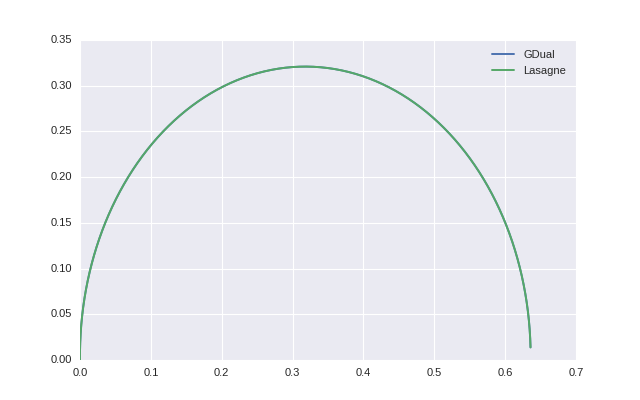

In [19]:
# Initial state
x = 0
y = 0
theta = 0

# two quadrotor neural networks
quad = VeloQuadrotor(GNeuroController([3, 5, 5, 2]))
tquad = VeloQuadrotor(TNeuroController([3, 5, 5, 2]))
tquad.set_parameters([x.constant_cf for x in quad.get_parameters()])

plt.figure(figsize=(8, 5))

for name, quadrotor, integrator in [('GDual', quad, gdual_euler), ('Lasagne', tquad, euler)]:
    state = [x,y,theta]
    positions = [state]
    
    if name == 'GDual':
        state = [gdual(x) for x in state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        
        if name == 'GDual':
            positions.append([x.constant_cf for x in state])
        else:
            positions.append(state)

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)

plt.legend()

<IPython.core.display.Javascript object>


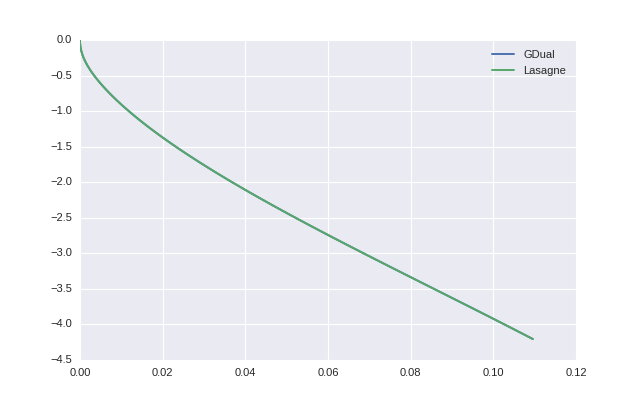

In [20]:
# Initial state
x = 0
y = 0
theta = 0

# two quadrotor neural networks
quad = GraviQuadrotor(GNeuroController([6, 5, 5, 2]))
tquad = GraviQuadrotor(TNeuroController([6, 5, 5, 2]))
tquad.set_parameters([x.constant_cf for x in quad.get_parameters()])

plt.figure(figsize=(8, 5))

for name, quadrotor, integrator in [('GDual', quad, gdual_euler), ('Lasagne', tquad, euler)]:
    state = [x,y,theta,0,0,0]
    positions = [state]
    
    if name == 'GDual':
        state = [gdual(x) for x in state]

    for i in range(100):
        state = integrator(state, quadrotor.control, 0.01)
        if name == 'GDual':
            positions.append([x.constant_cf for x in state])
        else:
            positions.append(state)

    positions = np.array(positions)

    plt.plot(positions[:, 0], positions[:, 1], label=name)

plt.legend()

Learning
=========

The maximum time of 5 seconds is actually quite limited close to what is necessary to reach 0, 0 from any position. It can be increased to 10, which doesn't change much however

In [21]:
# simulation parameters
integrator = runge_kutta4
max_time = 5
dt = 0.25
num_steps = int(max_time / dt)

# initial condition parameters
x_range = (-1, 1)
y_range = (-1, 1)
theta_range = (-np.pi, np.pi)

PSO
===

In [42]:
import PyGMO

/usr/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


#### Use big theano expression including the integration

In [ ]:
n_units = [2, 10, 2]
quad = VeloQuadrotor(FeatureExtend(TNeuroController(n_units)))
ms_pso_quad = TVeloQuadrotor(TFeatureExtend(TMultistepNeuroController(n_units, quad.controller.get_parameters())))

integrator = runge_kutta4

input_var = T.matrix('state 0')
target = T.matrix('target')

state = input_var

loss = None

rho = 0.75

# forward pass
for i in range(num_steps):
    state = integrator(state, ms_pso_quad.control, dt)
    if loss is None:
        loss = lasagne.objectives.squared_error(state[:, :2], target[:, :2]).mean()
    else:
        loss = rho * loss + lasagne.objectives.squared_error(state[:, :2], target[:, :2]).mean()

ms_pso_quad.controller.controller.input_var = input_var
ms_pso_quad.controller.controller.create_function(state)
ms_pso_quad.controller.controller.create_sgd(loss, target, learning_rate)

In [ ]:
class Phototaxis(PyGMO.problem.base_stochastic):
    def __init__(self):
        # evil, I know...
        global ms_pso_quad

        dim = len(ms_pso_quad.get_parameters())
        
        super(Phototaxis, self).__init__(dim)
    
        self.set_bounds(-1, 1)
                
    def _objfun_impl(self, x):
        global ms_pso_quad
        
        np.random.seed(self.seed)
        
        ms_pso_quad.set_parameters(x)
        
        x = np.random.rand(trials) * (x_range[1] - x_range[0]) + x_range[0]
        y = np.random.rand(trials) * (y_range[1] - y_range[0]) + y_range[0]
        theta = np.random.rand(trials) * (theta_range[1] - theta_range[0]) + theta_range[0]

        state = np.vstack([x, y, theta]).transpose()
        
        return (float(ms_pso_quad.controller.controller.test(state, np.zeros((trials, 2)))),)
        
    def human_readable_extra(self):
        return "\n\t Info: "

#### Alternatively: simple network an separated intergration

In [52]:
if False:
    class Phototaxis(PyGMO.problem.base_stochastic):
        def __init__(self):
            self.quad = VeloQuadrotor(FeatureExtend(TNeuroController([2, 10, 2])))

            dim = len(self.quad.get_parameters())

            super(Phototaxis, self).__init__(dim)

            self.set_bounds(-1, 1)

        def _objfun_impl(self, x):
            rho = 0.75

            np.random.seed(self.seed)

            self.quad.set_parameters(x)

            x = np.random.rand(trials) * (x_range[1] - x_range[0]) + x_range[0]
            y = np.random.rand(trials) * (y_range[1] - y_range[0]) + y_range[0]
            theta = np.random.rand(trials) * (theta_range[1] - theta_range[0]) + theta_range[0]

            state = np.vstack([x, y, theta]).transpose()

            loss = 0

            for i in range(num_steps):
                state = integrator(state, self.quad.control, dt)

                if state.ndim > 1:
                    loss = rho * loss + np.mean(state[:, 0]**2 + state[:, 1]**2)
                else:
                    loss = rho * loss + state[0]**2 + state[1]**2

            batch_loss = loss

            return (batch_loss / trials,)

        def human_readable_extra(self):
            return "\n\t Info: "

Training starts here

In [44]:
# training parameters
trials = 100
individuals = 100
generations = 100

In [45]:
algorithm = PyGMO.algorithm.pso_gen(gen=1)

problem = Phototaxis()

population = PyGMO.population(problem, individuals)

problem.set_bounds(-10, 10)

In [46]:
#for _ in tqdm.trange(generations):
for i in range(generations):
    population = algorithm.evolve(population)
    print(i, population.mean_velocity(), population.champion.f)

0 4.259070139307777 (0.0039611907384447895,)
1 3.409274338304985 (0.004579574662237497,)
2 3.5306295552829097 (0.004399688737714636,)
3 3.11535246292908 (0.00131270501242474,)
4 3.0664200410990565 (0.0013211500745646115,)
5 3.0099890117637016 (0.001477218909914895,)
6 2.8018803761797866 (0.0015144593235752548,)
7 2.769100471716858 (0.0013643659319630206,)
8 2.6867231673934397 (0.0015929447712546571,)
9 2.5797649080902976 (0.001429283991932448,)


In [47]:
population.champion

	Decision vector:	[0.56966734327213575, 1, -0.0048914093350710189, 0.55230392968194619, -1,  ... ]
	Constraints vector:	[]
	Fitness vector:		[0.001429283991932448]

### test it

In [48]:
#n_units = [5, 10, 2]
n_units = [2, 10, 2]

quad = VeloQuadrotor(FeatureExtend(TNeuroController(n_units)))
integrator = runge_kutta4

In [49]:
quad.set_parameters(population.champion.x)

<IPython.core.display.Javascript object>


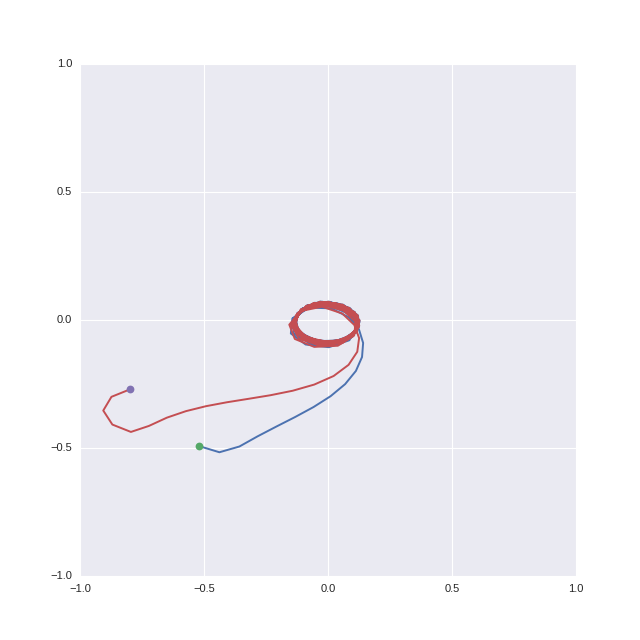

(-1, 1)

In [50]:
# Initial state
x = np.random.rand() * (x_range[1] - x_range[0]) + x_range[0]
y = np.random.rand() * (y_range[1] - y_range[0]) + y_range[0]
theta = np.random.rand() * (theta_range[1] - theta_range[0]) + theta_range[0]

#positions = [[x,y,theta,0,0,0]]
positions = [[x,y,theta]]
#positions = [[10, 10, 0]]

x = np.random.rand() * (x_range[1] - x_range[0]) + x_range[0]
y = np.random.rand() * (y_range[1] - y_range[0]) + y_range[0]
theta = np.random.rand() * (theta_range[1] - theta_range[0]) + theta_range[0]

positions2 = [[x, y, theta]]

state = np.array([positions[0], positions2[0]])#[0]

for i in range(num_steps + 100):
    state = integrator(state, quad.control, dt)
    positions.append(state[0].copy())
    positions2.append(state[1].copy())

positions = np.array(positions)
positions2 = np.array(positions2)

plt.figure(figsize=(8, 8))
plt.plot(positions[:, 0], positions[:, 1])
plt.plot(positions[0, 0], positions[0, 1], 'o')

plt.plot(positions2[:, 0], positions2[:, 1])
plt.plot(positions2[0, 0], positions2[0, 1], 'o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

SGD
===

Stochastic Gradient Descent with the huge compiled integration + control theano expression (TMultistepNeuroController)

In [22]:
# training parameters
num_epochs = 50
num_batches = 10
num_initial_conditions_per_batch = 10
num_initial_conditions = num_initial_conditions_per_batch * num_batches
num_overall_batches = num_batches * num_epochs
learning_rate = 0.0001

Optionally don't run the following line to use the PSO result and start training from there.

In my experiments I found that this doesn't give much benefit typically and depending on the learning rate might make matters worse.

In [24]:
#n_units = [5, 10, 2]
#n_units = [3, 10, 2]
n_units = [2, 10, 2]

quad = VeloQuadrotor(FeatureExtend(TNeuroController(n_units)))

In [ ]:
ms_quad = TVeloQuadrotor(TFeatureExtend(TMultistepNeuroController(n_units, quad.controller.get_parameters())))
ms_integrator = runge_kutta4

losses = []

In [25]:
input_var = T.matrix('state 0')
target = T.matrix('target')

In [27]:
state = input_var

loss = None

rho = 0.75

# forward pass
for i in range(num_steps):
    state = ms_integrator(state, ms_quad.control, dt)
    if loss is None:
        loss = lasagne.objectives.squared_error(state[:, :2], target[:, :2]).mean()
    else:
        loss = rho * loss + lasagne.objectives.squared_error(state[:, :2], target[:, :2]).mean()

In [28]:
ms_quad.controller.controller.input_var = input_var
ms_quad.controller.controller.create_function(state)
ms_quad.controller.controller.create_sgd(loss, target, learning_rate)

In [29]:
for k in range(num_overall_batches): # tqdm.t
    # Initial state
    #x = -10 * np.ones(num_initial_conditions_per_batch)
    #y = -10 * np.ones(num_initial_conditions_per_batch)
    #theta = 0 * np.ones(num_initial_conditions_per_batch)
    x = np.random.rand(num_initial_conditions_per_batch) * (x_range[1] - x_range[0]) + x_range[0]
    y = np.random.rand(num_initial_conditions_per_batch) * (y_range[1] - y_range[0]) + y_range[0]
    theta = np.random.rand(num_initial_conditions_per_batch) * (theta_range[1] - theta_range[0]) + theta_range[0]

    state = np.array([x,y,theta]).transpose()

    loss = ms_quad.controller.controller.training(state, np.zeros((num_initial_conditions_per_batch, n_units[-1])))
    
    if k % num_epochs == 0:
        print(k, loss)

    losses.append(loss)

0 3.21797907162581
50 0.3217681207139651
100 0.1636822574980205
150 0.16310422518553322
200 0.18688768782874457
250 0.12206708784156112
300 0.15093441935297813
350 0.12927476835958496
400 0.12905455981774674
450 0.10263925520429755


<IPython.core.display.Javascript object>


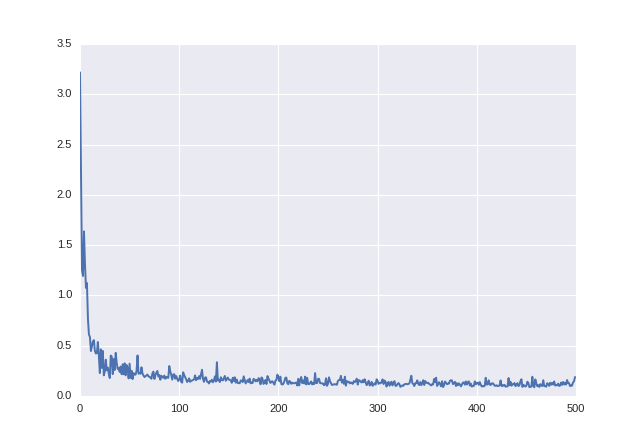

In [33]:
plt.figure()
#plt.plot(np.convolve(losses, np.ones(1000) / 1000))
plt.plot(losses)

In [40]:
quad.set_parameters(ms_quad.controller.get_parameters())

<IPython.core.display.Javascript object>


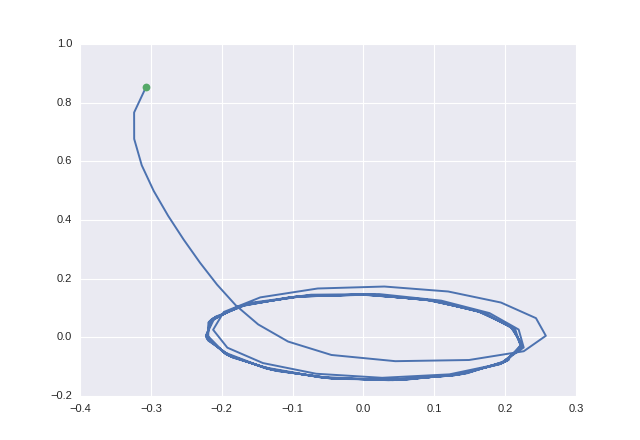

In [41]:
# Initial state
x = np.random.rand() * (x_range[1] - x_range[0]) + x_range[0]
y = np.random.rand() * (y_range[1] - y_range[0]) + y_range[0]
theta = np.random.rand() * (theta_range[1] - theta_range[0]) + theta_range[0]

positions = [[x,y,theta]]
#positions = [[-1,-1,0]]

state = positions[0]

for i in range(num_steps + 100):
    state = integrator(state, quad.control, dt)
    positions.append(state.copy())

positions = np.array(positions)

plt.figure()
plt.plot(positions[:, 0], positions[:, 1])
plt.plot(positions[0, 0], positions[0, 1], 'o')